# Let's see if it's working

In [1]:
import torch

import matplotlib.pyplot as plt

from nn.sequential import *
from nn.activation import *
from nn.linear import *
from nn.loss import *
from trainer import Trainer

In [2]:
def gen_data(n):
    x = torch.rand((2 * n, 2))
    pi = torch.acos(torch.zeros(1)).item() * 2
    target = ((x - torch.Tensor([0.5, 0.5])).pow(2).sum(dim=1) <= 1/(2*pi)) * 1

    x_train, x_test = x[:n], x[n:]
    y_train, y_test = target[:n], target[n:]
    return x_train, x_test, y_train.view(-1, 1), y_test.view(-1, 1)

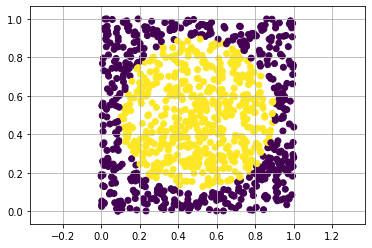

In [13]:
# Create test data
x_train, x_test, y_train, y_test = gen_data(1000)

# Plot test data
plt.scatter(x_train.numpy()[:,0], x_train.numpy()[:,1], c=y_train[:, 0])
plt.axis('equal')
plt.grid()
plt.show()

In [22]:
LinNet_ours = Sequential((
    Linear(2, 25),
    ReLU(),
    Linear(25, 25),
    ReLU(),
    Linear(25, 25),
    ReLU(),
    Linear(25, 1)),
    MSELoss()
)

LinNet_theirs = torch.nn.Sequential(
    torch.nn.Linear(2, 25),
    torch.nn.ReLU(),
    torch.nn.Linear(25, 25),
    torch.nn.ReLU(),
    torch.nn.Linear(25, 25),
    torch.nn.ReLU(),
    torch.nn.Linear(25, 1)
)
print(f'ours {LinNet_ours}, theirs {LinNet_theirs}')

print(Linear(25, 25))

ours Sequential(
	(0): Linear(in_features=2, out_features=25, bias=True)
	(1): ReLU()
	(2): Linear(in_features=25, out_features=25, bias=True)
	(3): ReLU()
	(4): Linear(in_features=25, out_features=25, bias=True)
	(5): ReLU()
	(6): Linear(in_features=25, out_features=1, bias=True)
), theirs Sequential(
  (0): Linear(in_features=2, out_features=25, bias=True)
  (1): ReLU()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): ReLU()
  (4): Linear(in_features=25, out_features=25, bias=True)
  (5): ReLU()
  (6): Linear(in_features=25, out_features=1, bias=True)
)
Linear(in_features=25, out_features=25, bias=True)


In [23]:
# Iterate over samples in x
loss_fn_theirs = torch.nn.MSELoss()
optimizer_theirs = torch.optim.SGD(LinNet_theirs.parameters(), lr=0.01)
train_loss_ours = []
train_loss_theirs = []
n_epochs = 15
for e in range(n_epochs):
    for i in range(len(x_train)):
        # Get one data sample
        x_sample = x_train[i:i+1]
        y_sample = y_train[i:i+1].float()

        # Forward ours
        out_ours = LinNet_ours(x_sample)
        loss_ours = LinNet_ours.loss(out_ours, y_sample)
        train_loss_ours.append(loss_ours)
        #print(f'our ours: {out}')

        # Forward theirs
        out_theirs = LinNet_theirs(x_sample)
        loss_theirs = loss_fn_theirs(out_theirs, y_sample)
        train_loss_theirs.append(loss_theirs.item())
        #print(f'our theirs: {out}')

        # Backward ours
        LinNet_ours.backward()

        # Backward theirs
        optimizer_theirs.zero_grad()
        loss_theirs.backward()
        optimizer_theirs.step()

        # Update params
        LinNet_ours.update_params(optim='adam', lr=0.01)
    print(f'finished epoch {e} with train loss: {sum(train_loss_ours)/len(train_loss_ours)} (ours), {sum(train_loss_theirs)/len(train_loss_theirs)} (theirs)')

finished epoch 0 with train loss: nan (ours), 0.25465951799275355 (theirs)
finished epoch 1 with train loss: nan (ours), 0.24516922471881844 (theirs)
finished epoch 2 with train loss: nan (ours), 0.23374787674006076 (theirs)


KeyboardInterrupt: 

In [19]:
t = Trainer(nb_epochs=5)
t.fit(LinNet_ours, x_train, y_train, x_test, y_test, batch_size=32)

# Epoch 1/5:	 loss=0.03	 loss_val=0.03
# Epoch 2/5:	 loss=0.03	 loss_val=0.03
# Epoch 3/5:	 loss=0.03	 loss_val=0.03
# Epoch 4/5:	 loss=0.03	 loss_val=0.03
# Epoch 5/5:	 loss=0.03	 loss_val=0.03


([0.03, 0.03, 0.03, 0.03, 0.03], [0.03, 0.03, 0.03, 0.03, 0.03])

In [7]:
x_train.size(), y_train.size(), x_test.size(), y_test.size()

(torch.Size([1000, 2]),
 torch.Size([1000, 1]),
 torch.Size([1000, 2]),
 torch.Size([1000, 1]))

In [6]:
LinNet_ours(x_train[0:1])

tensor([[-0.1846]])

In [16]:
w, b = LinNet_ours.modules[0].param()
w.size()

torch.Size([2, 25])

In [26]:
torch.nn.Linear(2, 25).weight.size()

torch.Size([25, 2])

In [27]:
theirs = torch.nn.Sequential(
    torch.nn.Linear(2, 25),
    torch.nn.ReLU()
)
ours = Sequential((
    Linear(2, 25),
    ReLU()
), MSELoss())

In [30]:
ours(x_train[0:3])

tensor([[0.0000, 0.0351, 0.0000, 0.1024, 0.0376, 0.0731, 0.0000, 0.0000, 0.0000,
         0.1587, 0.1263, 0.0000, 0.0000, 0.1916, 0.1768, 0.0000, 0.2066, 0.0000,
         0.1590, 0.1520, 0.0000, 0.0000, 0.0000, 0.1227, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0408, 0.0000, 0.0038, 0.0000, 0.0000, 0.0000,
         0.1966, 0.0963, 0.0000, 0.0000, 0.2503, 0.1978, 0.0000, 0.2009, 0.0000,
         0.2263, 0.1499, 0.0000, 0.0000, 0.0000, 0.1046, 0.0000],
        [0.0000, 0.1245, 0.0191, 0.1892, 0.1138, 0.1609, 0.0000, 0.0000, 0.0000,
         0.1076, 0.1829, 0.0000, 0.0000, 0.1134, 0.1608, 0.0000, 0.2476, 0.0000,
         0.1110, 0.1723, 0.0000, 0.0435, 0.0000, 0.1375, 0.0000]])

In [32]:
x_train[0:3].size(), y_train[0:3].size()

(torch.Size([3, 2]), torch.Size([3, 1]))

In [61]:
x.size()

torch.Size([10, 3])

In [31]:
theirs(x_train[0:3])

tensor([[0.5620, 0.0000, 0.5469, 0.0979, 0.0550, 0.0000, 0.4722, 0.0000, 0.1335,
         0.4241, 0.0703, 0.0000, 0.0172, 0.0000, 0.5361, 0.0000, 0.0199, 0.6729,
         0.0000, 0.0000, 0.4976, 0.1100, 0.4531, 0.5209, 0.0000],
        [0.5985, 0.0000, 0.6676, 0.1907, 0.2666, 0.0000, 0.4343, 0.0000, 0.0000,
         0.2640, 0.2206, 0.0000, 0.0715, 0.0000, 0.7323, 0.0000, 0.1188, 0.8340,
         0.0000, 0.0000, 0.7341, 0.0000, 0.7611, 0.6893, 0.0000],
        [0.4616, 0.0000, 0.4815, 0.0000, 0.0000, 0.0000, 0.6846, 0.0000, 0.3829,
         0.8096, 0.0000, 0.0000, 0.0876, 0.0000, 0.1546, 0.0000, 0.0000, 0.4733,
         0.0000, 0.0000, 0.3650, 0.1788, 0.2071, 0.3179, 0.0000]],
       grad_fn=<ReluBackward0>)

In [8]:
x = torch.empty((10, 3)).normal_()
y = torch.empty((10, 2)).normal_()


In [9]:
LinNet = Sequential((
    Linear(3, 25),
    Linear(25, 3),
    ReLU()
), MSELoss())

In [10]:
LinNet(x)

tensor([[0.5182, 0.0000, 0.0000],
        [0.8693, 0.0000, 0.0000],
        [0.2715, 0.0000, 0.0000],
        [0.6622, 0.0000, 0.0000],
        [0.3809, 0.0000, 0.0000],
        [0.3116, 0.0000, 0.0000],
        [0.4967, 0.0000, 0.0000],
        [0.5671, 0.0000, 0.0000],
        [0.3892, 0.0000, 0.0626],
        [0.5750, 0.0000, 0.0227]])

In [59]:
LinNet_theirs = torch.nn.Sequential(
    torch.nn.Linear(3, 25),
    torch.nn.Linear(25, 3),
    torch.nn.ReLU()
)

In [60]:
LinNet_theirs(x)

tensor([[0.2918, 0.1273, 0.0000],
        [0.5860, 0.2191, 0.0000],
        [0.0000, 0.0000, 0.0322],
        [0.6050, 0.5656, 0.0000],
        [0.1084, 0.0000, 0.0000],
        [0.5300, 0.4413, 0.2890],
        [0.0000, 0.5738, 0.1186],
        [0.0000, 0.0000, 0.0057],
        [0.0825, 0.0000, 0.0070],
        [0.0000, 0.0404, 0.2034]], grad_fn=<ReluBackward0>)

In [11]:
l = torch.nn.Linear(3, 25)
l.weight.size(), l.bias.size()

(torch.Size([25, 3]), torch.Size([25]))

In [16]:
l.bias.T == l.bias

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True])

In [24]:
x.pow(2)

tensor([[8.2030e-01, 4.4425e-03, 1.5302e-01],
        [1.7701e+00, 5.9286e-01, 1.0848e+00],
        [1.1806e-01, 9.8196e+00, 1.8282e+00],
        [4.6084e-02, 1.3850e+00, 2.8176e-02],
        [2.2127e-02, 2.3799e+00, 8.6143e-02],
        [3.8281e-03, 8.8605e-01, 1.5986e+00],
        [2.0316e-01, 2.8668e-01, 1.1669e-01],
        [4.6517e-03, 1.6201e-01, 9.6782e-02],
        [2.3316e-01, 5.4713e-02, 2.4036e+00],
        [5.8316e-01, 2.3731e-01, 1.2434e+00]])